# Trabalho 1 - Treinamento do  modelo 1
### by Lucas de Jesus B. Gonçalves

In [1]:
import os
import gc
import torch
import torchvision.io as tvio
import torch.functional as F
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchsummary import summary

In [2]:
class SportsDataset(Dataset):
    def __init__(self, caminho, multiplicador=1, augmentate=True):
        #caminho base para o dataset
        self.caminho_base = caminho

        #multiplicador (numero de repetições para usar o dataset, já que as transformações são aleatórias)
        #para dar maior volume de dados
        self.multiplicador = multiplicador

        #dicionario que relaciona uma label com um indice: labels -> index
        self.tabela, self.labels_index_dict =  self.obter_tabela()
        self.len_tabela = len(self.tabela)

        if augmentate:
            self.transforms = v2.Compose([
                v2.RandomResizedCrop(size=(224, 224), scale=(0.6, 1.0), ratio=(0.75, 1.33), antialias=True),
                v2.RandomHorizontalFlip(p=0.5),
                v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                v2.RandomRotation(degrees = 20),
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.45536014, 0.47005367,0.4714128 ], std=[0.23237318, 0.23046514, 0.24005896]), # normalização segundo o dataset
            ])
        else:
            self.transforms = v2.Compose([
                v2.Resize(size=(224, 224), antialias=True),  # Fixed resize to 224x224
                v2.ToDtype(torch.float32, scale=True),
                v2.Normalize(mean=[0.45536014, 0.47005367, 0.4714128], std=[0.23237318, 0.23046514, 0.24005896]),  # Normalization
            ])

    #------------metodos sobrecarregados de Dataset-----------------
    def __getitem__(self, entry):
        caminho, label =  self.tabela[entry % self.len_tabela]
        label_index = self.labels_index_dict[label]
 
        #retorna o tensor representando uma imagem, juntamente com seu label , o indice
        imagem = tvio.read_image(caminho, mode = tvio.ImageReadMode.RGB)
        imagem = self.transforms(imagem)
        return imagem, label_index
        
    def __len__(self):
        return self.len_tabela*self.multiplicador

    #------------metodos auxiliares -------------------------------

    #retorna uma lista de tuplas contendo o caminho de uma imagem e sua categoria respectiva
    def obter_tabela(self):
        tabela = []
        labels = {}
    
        #vasculha o caminho base em procura de pastas contendo imagens de cada categoria
        for index, pasta_categoria in enumerate(os.listdir(self.caminho_base)):
            labels[pasta_categoria] = index;
                          
            #vasculha cada imagem dentro de uma pasta de dada categoria
            for imagem in os.listdir(os.path.join(self.caminho_base, pasta_categoria)):
                entrada = (os.path.join(self.caminho_base, pasta_categoria, imagem), pasta_categoria)
                tabela.append(entrada)

        return tabela, labels

    def class_weights(self):
         
        label_counts = np.zeros(len(self.labels_index_dict))
        for _, label in self.tabela:
            label_index = self.labels_index_dict[label]
            label_counts[label_index] += 1
        
        # Calculate os pesos (inverso da contagem)
        weights = 1.0 / label_counts


        # Calcula os pesos para cada amostra
        sample_weights = []
        for _, label in self.tabela:
            label_index = self.labels_index_dict[label]
            sample_weights.append(weights[label_index])
            
        return torch.Tensor(sample_weights*self.multiplicador)

In [3]:
#bloco residual para resnet 50+
class Bottleneck(nn.Module):
    #fator de expansão para o resnet
    expansion = 4
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False) #mantem a dimensão da imagem 
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False) #reduz a dim da imagem para floor((N - 1 + stride)/stride)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False) #mantem a dimensão da imagem mas aumenta o n de canais
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.downsample = downsample
        self.stride = stride

        #função de ativação
        self.relu = nn.LeakyReLU(negative_slope=0.01)


    def forward(self, x):
        #backup da entrada (residual)
        residual = x.clone()

        #aplica as convoluções
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.batch_norm3(self.conv3(x))
        
        #se um módulo estiver definido para ao residual, aplica o valor
        if self.downsample is not None:
            residual = self.downsample(residual)
            
        #combina a saida com o valor desviado (puro ou passado primeiro para outro modulo)
        x += residual
        x = self.relu(x)
        
        return x

In [4]:
import torch.profiler

class MeuModelo(nn.Module):
    def __init__(self, tipo_bloco, camadas, num_classes = 100):
        

        #chama o construtor da superclasse
        super().__init__()

        self.canais_entrada = 64

        # 3 canais de imagem (RGB), 64 canais de saida, imagens, kernel de 7x7de tamanho
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias=False), #cai para 112x112
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01)
        )
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1) #cai para 56x56
        
        self.layer0 = self._nova_camada(tipo_bloco, 64, camadas[0], stride = 1)  #mantem em 56x56 (stride=1)
        self.layer1 = self._nova_camada(tipo_bloco, 128, camadas[1], stride = 2) #cai para 28x28 (stride=2)
        self.layer2 = self._nova_camada(tipo_bloco, 256, camadas[2], stride = 2) #cai para 14x14 (stride=2)
        self.layer3 = self._nova_camada(tipo_bloco, 512, camadas[3], stride = 2) #cai para 7x7 (stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1) #cai para 1x1, então fica 512*expansion canais de 1x1
        
        self.fc =  nn.Linear(512*tipo_bloco.expansion, num_classes)
    

        #chama função de inicialização dos pesos
        self.init_weights()

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)

        #aplica um flatten antes da fully connected
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def _nova_camada(self, tipo_bloco, canais_saida, n_camadas, stride=1):
        downsample = None

        #se o stride for diferente de 1 ou o numero de canais de entrada for diferente do de saida,
        #isto é, uma redução na dimensão de cada canal ou alteração no numero de canais, aplicamos correção
        if stride != 1 or self.canais_entrada != canais_saida*tipo_bloco.expansion:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.canais_entrada, canais_saida*tipo_bloco.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(canais_saida*tipo_bloco.expansion)
            )
            
        camadas = []

        #adiciona o primeiro bloco separadamente (pois pode haver correções na função de downsample)
        camadas.append(tipo_bloco(self.canais_entrada, canais_saida, stride, downsample))

        #com o downsample aplicado, os canais de entrada dos proximos blocos serão iguais à canais_saida
        self.canais_entrada = canais_saida*tipo_bloco.expansion

        #adiciona o restante dos blocos
        for i in range(1, n_camadas):
            camadas.append(tipo_bloco(self.canais_entrada, canais_saida))

        #retorna o modelo sequencial equivalente da camada
        return nn.Sequential(*camadas)

    
    #inicializa pesos com inicialização xavier
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, a= 0.01, nonlinearity='leaky_relu') #para evitar problemas com relu
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    

    def treinar(self, train_loader, val_loader, num_epochs, cost_function, optimizer, scheduler = None, verbose=True):
        
        # Dispositivo para o processamento
        device = next(self.parameters()).device

        #ativa o autotuner do cuDNN = + performace
        torch.backends.cudnn.benchmark = True

        #ativa scaler para quando o gradiente é muito pequeno quando usando fp16
        scaler = torch.cuda.amp.GradScaler()

        #otimização gpu
        use_amp = True
        #-----------------------------------------------------------------------
    
        
        loss_history = {"train": [], "val":[]}
        accuracy_history = {"train": [], "val":[]}

        for epoch in range(num_epochs):
    
            # Loss acumulada para o treino
            acum_train_loss = 0
            acum_val_loss = 0
    
            # Numero de predições corretas
            acum_train_correct = 0
            acum_val_correct = 0
    
            samples = 0
            val_samples = 0

            self.train()
            # loop de treino para cada batch
            for batch_index, (train_x, train_y) in enumerate(train_loader):

                samples += train_y.size(0)

                 # Carrega os dados no dispositivo (GPU)
                train_images = train_x.to(device, non_blocking=True)
                train_labels = train_y.to(device, non_blocking=True)
                
                #Roda o foward com autocast para aproveitar do boost fp16 dos tensorcores
                with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
                   
                    train_output = self(train_images)
                    train_loss = cost_function(train_output, train_labels)

        
                # faz update da loss acumulada
                acum_train_loss += train_loss.item()
                
                # faz update na quantia de acertos de treino acumulados
                acum_train_correct += torch.sum(torch.eq(torch.argmax(train_output, dim=1), train_labels)).item()
    
                # Backward e update
                # Zera o gradiente para evitar BO (set to none = + desempenho)
                optimizer.zero_grad(set_to_none=True)    

                #aplica escala na loss e aplica o backward
                scaler.scale(train_loss).backward()


                #se tiver algum NaN ou inf, optimizer.step() não é executado
                scaler.step(optimizer)

                #atualiza o scaler para a proxima iteração
                scaler.update()
    
            # Validação
            self.eval()
            
            # Não precisa calcular gradiente para a validação
            with torch.no_grad():  
                for batch_index, (val_images, val_labels) in enumerate(val_loader):

                    val_samples += val_labels.size(0)
                    val_images, val_labels = val_images.to(device, non_blocking=True), val_labels.to(device, non_blocking=True)

                    with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
                        val_output = self(val_images)
                        val_loss = cost_function(val_output, val_labels)
                        
                    acum_val_loss += val_loss.item()
                    acum_val_correct += torch.sum(torch.eq(torch.argmax(val_output, dim=1), val_labels)).item()
                    
                    del  val_images, val_labels, val_output
                    
    
            # Calcula as metricas para a epoca
            epoch_train_loss = acum_train_loss / len(train_loader)
            epoch_val_loss = acum_val_loss / len(val_loader)
            
            epoch_train_accuracy = acum_train_correct / samples
            epoch_val_accuracy = acum_val_correct / val_samples

            #atualiza o scheduller
            if scheduler is not None:
                #atualiza a lr
                lr_antiga = optimizer.param_groups[0]["lr"]
                scheduler.step()
                lr_nova = optimizer.param_groups[0]["lr"]

                print(f"Epoch {epoch + 1}/{num_epochs} - LR {lr_antiga}-->>{lr_nova}:")
            else:
                print(f"Epoch {epoch + 1}/{num_epochs}")
    
            # Salva a loss e a acuracia de treino e validação
            loss_history["train"].append(epoch_train_loss)
            loss_history["val"].append(epoch_val_loss)
            accuracy_history["train"].append(epoch_train_accuracy)
            accuracy_history["val"].append(epoch_val_accuracy)
    
            if verbose:
                print(f"  Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}")
                print(f"  Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

        return loss_history, accuracy_history

In [5]:
from torch.utils.data import WeightedRandomSampler

train_ds = SportsDataset("train", 4, augmentate=True)
valid_ds = SportsDataset("valid", 1, augmentate=False)

#calcula os pesos do dataset, para configurar o amostrador
train_sample_weights = train_ds.class_weights()
valid_sample_weights = valid_ds.class_weights()

# Cria os amostradores
train_sampler = WeightedRandomSampler(train_sample_weights, len(train_sample_weights))
valid_sampler = WeightedRandomSampler(valid_sample_weights, len(valid_sample_weights))

In [6]:
batch_size = 192

train_loader = DataLoader(train_ds, batch_size=batch_size, pin_memory=True, num_workers=6, sampler= train_sampler)
valid_loader = DataLoader(valid_ds, batch_size=100, pin_memory=True, num_workers=6, sampler= valid_sampler)

In [7]:
import torch.optim.lr_scheduler as lr_scheduler

#verifica se tem gpu disponível e configura automaticamente
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#cria o modelo e o atribui para o melhor dispositivo encontrado

#modelo baseado no resnet
modelo = MeuModelo(Bottleneck, [1, 2, 3, 1]).to(device, non_blocking=True)

#configuração do otimizador
learning_rate = 1e-2

#
decay = 0.08

#configuração epocas
epochs = 60

#optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate, weight_decay = decay, fused=True)
optimizer = torch.optim.AdamW(modelo.parameters(), lr=learning_rate, weight_decay = decay, fused=True)
#optimizer = torch.optim.SGD(modelo.parameters(), lr=learning_rate, weight_decay=decay, momentum = 0.90, fused=True)
#optimizer = torch.optim.RMSprop(modelo.parameters(), lr=learning_rate, weight_decay=decay, momentum = 0.90, foreach=True)

#scheduler = None
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6, threshold=1e-2, threshold_mode='abs')
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, div_factor= 30, steps_per_epoch=1, epochs=epochs)
#scheduler = lr_scheduler.CyclicLR(optimizer, base_lr=learning_rate, max_lr = 0.01, step_size_up = 15, step_size_down=25, mode="triangular2")
#scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0.0001)
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
#scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=epochs)

#função de loss
cost = nn.CrossEntropyLoss()

In [8]:
summary(modelo, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
         LeakyReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
         LeakyReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
        LeakyReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [9]:
hist = modelo.treinar(train_loader, valid_loader,  epochs, cost, optimizer, scheduler=scheduler, verbose=True)

Epoch 1/60 - LR 0.00033333333333333305-->>0.00041563001819447387:
  Train Loss: 3.1356, Train Accuracy: 0.2324
  Val Loss: 2.5661, Val Accuracy: 0.3780
Epoch 2/60 - LR 0.00041563001819447387-->>0.0006597175578789468:
  Train Loss: 2.0302, Train Accuracy: 0.4578
  Val Loss: 1.7581, Val Accuracy: 0.5420
Epoch 3/60 - LR 0.0006597175578789468-->>0.0010572838439735308:
  Train Loss: 1.5631, Train Accuracy: 0.5694
  Val Loss: 1.5210, Val Accuracy: 0.6100
Epoch 4/60 - LR 0.0010572838439735308-->>0.0015947902334334813:
  Train Loss: 1.3665, Train Accuracy: 0.6160
  Val Loss: 1.4783, Val Accuracy: 0.6140
Epoch 5/60 - LR 0.0015947902334334813-->>0.002253932590833593:
  Train Loss: 1.2038, Train Accuracy: 0.6606
  Val Loss: 1.7415, Val Accuracy: 0.5820
Epoch 6/60 - LR 0.002253932590833593-->>0.003012264613746731:
  Train Loss: 1.0918, Train Accuracy: 0.6865
  Val Loss: 1.4344, Val Accuracy: 0.6340
Epoch 7/60 - LR 0.003012264613746731-->>0.003843962214651599:
  Train Loss: 0.9481, Train Accuracy: 

In [10]:
torch.save(modelo, "/home/lucas/mestrado/trabalho1/modelo1")

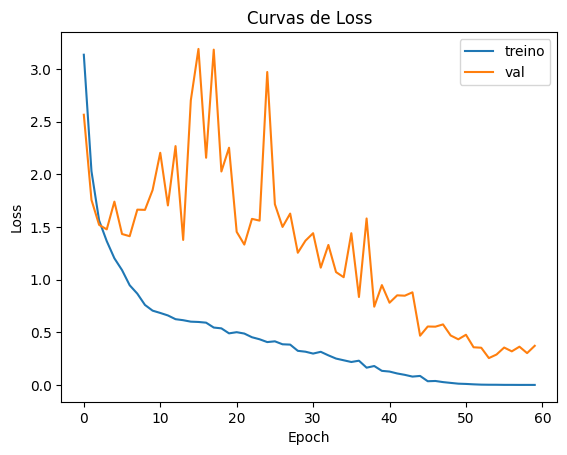

In [11]:
loss, acc = hist

plt.figure()
plt.plot(loss["train"], label="treino")
plt.plot(loss["val"], label="val")

plt.xlabel("Epoch") 
plt.ylabel("Loss") 
plt.title("Curvas de Loss") 
plt.legend()
plt.show()

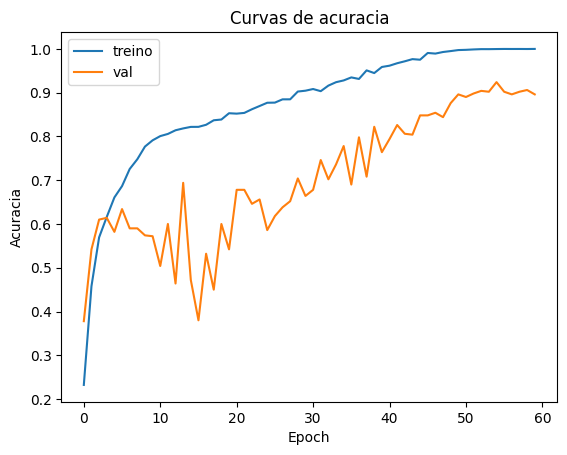

In [12]:
plt.figure()
plt.plot(acc["train"], label="treino")
plt.plot(acc["val"], label="val")

plt.xlabel("Epoch") 
plt.ylabel("Acuracia") 
plt.title("Curvas de acuracia") 
plt.legend()
plt.show()

In [13]:
#hist = modelo.treinar(train_loader, valid_loader,  epochs, cost, optimizer, scheduler=scheduler, verbose=True)